# Zastosowania DFT
Laboratorium 9 - Metody Obliczeniowe w Nauce i Technice

In [38]:
import os
from math import ceil
import cmath
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.feature import peak_local_max
from PIL import Image, ImageFont, ImageDraw
# import cv2

In [3]:
def load_image(img_path: str, **kwargs) -> np.ndarray:
    invert: bool = kwargs.get("invert", False)
    to_grey_scale: bool = kwargs.get("gscale", False)

    image = imread(img_path)
    if invert:
        image = np.invert(image)
    if to_grey_scale:
        image = rgb2gray(image)

    return image

In [4]:
def show_image(
    img,
    figsize: tuple[float, float] = (8, 8),
    dpi: int = 120,
    cmap = "gray",
    title: str | None = None
) -> None:
    fig, ax = plt.subplots()
    fig.figsize = figsize
    fig.dpi = dpi
    if title is not None:
        ax.set_title(title)
    ax.set_axis_off()
    plt.imshow(img, cmap=cmap)

## Zadanie 1. Analiza obrazów.
- Wczytaj obraz przedstawiający tekst, dokonaj odwrócenia kolorów (czarne tło), a następnie jego transformacji do domeny częstotliwościowej za pomocą DFT. Przedstaw wartości fazy i modułu współczynników Fouriera (osobno).
- Wybierz  przykładowego  reprezentanta  grupy  -  wytnij  z  dużego  zdjęcia  wzorzec obiektu np. literę _e_ lub charakterystyczny fragment ryby z ławicy (`imcrop`).
- Wykorzystując transformację Fouriera oblicz korelację między wybranym wzorcem a całym obrazem<sup>1</sup>.
- Przedstaw otrzymany obraz wyjściowy oraz punkty, w których wykryto wystąpienie wzorca (nałóż je na obraz oryginalny).
- Znajdź liczbę wystąpień wzorca. Testy przeprowadź na dwóch zbiorach danych.

<sup>1</sup>`C = real( ifft2(fft2(galia) .* fft2(rot90(imp, 2), h, w)) );`

### Wczytanie obrazu i odwrócenie jego kolorów
Na początku wczytuję obraz i odwracam paletę kolorów, aby tło tekstu było czarne, a tekst biały.

#### Tekst

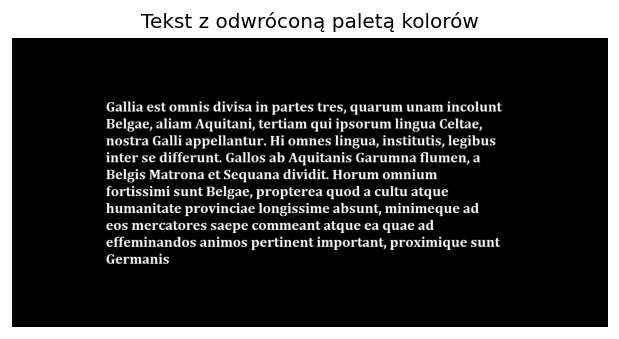

In [5]:
gs_text_image = load_image("./assets/ex1/galia.png", invert=True, gscale=True)
H, W = gs_text_image.shape
show_image(gs_text_image, figsize=(10, 8), title="Tekst z odwróconą paletą kolorów")

#### Pojedyncza litera (_e_)

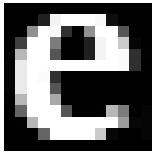

In [6]:
gs_letter = load_image("./assets/ex1/galia-e.png", invert=True, gscale=True)
show_image(gs_letter, figsize=(3, 2), dpi=40)

### Szybka transformacja Fouriera tekstu
Po przekształceniu tekstu i litery dokonuję transformacji obrazu, korzystając z FFT z biblioteki `NumPy` (`np.fft`).

In [7]:
# inverted_text_image_fft = np.fft.fftshift(np.fft.fft2(inverted_text_image))
# plt.figure(num=None, figsize=(8, 6), dpi=80)
# plt.imshow(np.log(abs(inverted_text_image_fft)), cmap='gray')

image_fft = np.fft.fft2(gs_text_image)

#### Wizualizacja wyników

##### Wykres argumentów wartości transformacji

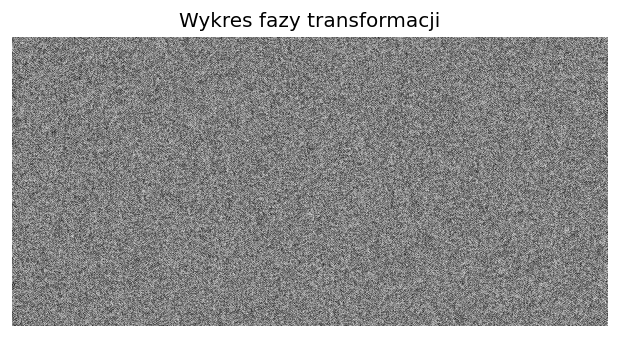

In [8]:
phase_image_fft = np.array([[cmath.phase(c) for c in row] for row in image_fft])
show_image(phase_image_fft, title="Wykres fazy transformacji")

##### Wykres modułów wartości transformacji
Wynik transformacji został zlogarytmowany, ponieważ wartości były zbyt duże i zbliżone do siebie.

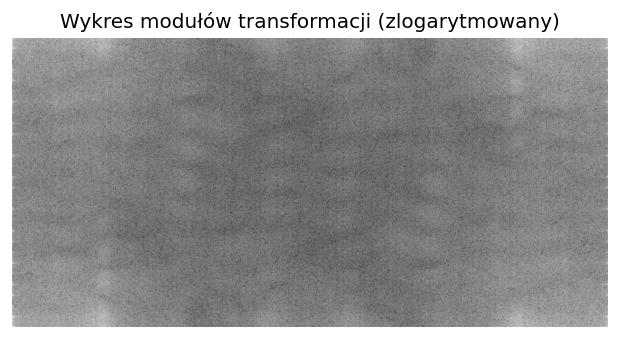

In [9]:
abs_image_fft = np.array([[abs(c) for c in row] for row in image_fft])
show_image(np.log(abs_image_fft), title="Wykres modułów transformacji (zlogarytmowany)")

#### Obliczenie korelacji wzorca z bazowym obrazem

In [10]:
def correlation(base_image, pattern) -> np.ndarray:
    H, W = base_image.shape
    return np.real(np.fft.ifft2(np.fft.fft2(base_image) * np.fft.fft2(np.rot90(pattern, 2), (H, W))))


C = correlation(gs_text_image, gs_letter)

##### Wyświetlenie korelacji

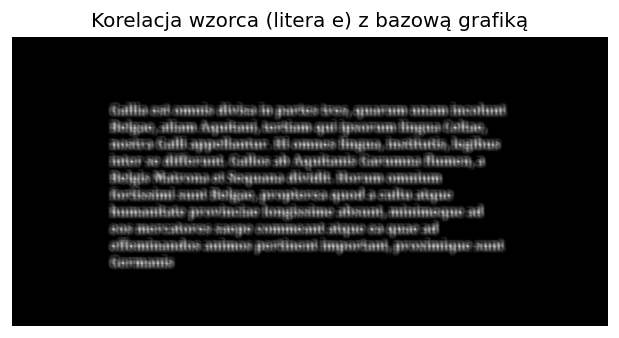

In [11]:
show_image(C, title="Korelacja wzorca (litera e) z bazową grafiką")

##### Wyświetlenie punktów, gdzie istnieją elementy bardzo podobne

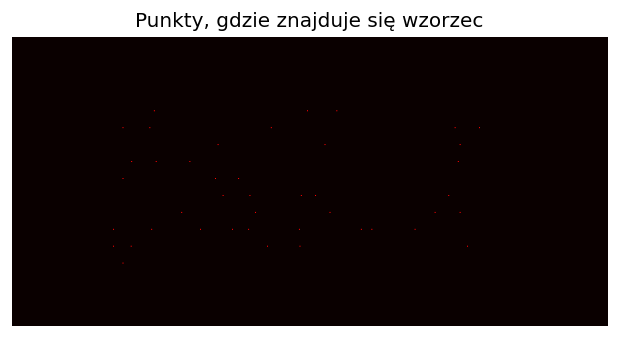

In [12]:
C_filtered = np.where(C > 50, C, 0)
show_image(C_filtered, cmap="hot", title="Punkty, gdzie znajduje się wzorzec")

##### Wyświetlenie znalezionych punktów na tle bazowej grafiki

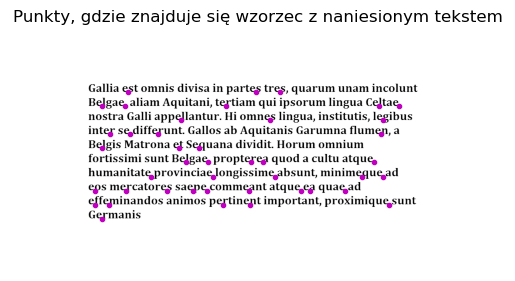

In [13]:
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(gs_text_image, cmap="Greys")

coordinates = peak_local_max(C, min_distance=12, threshold_rel=.95)
ax.plot(coordinates[:, 1], coordinates[:, 0], 'm.')

ax.set_title("Punkty, gdzie znajduje się wzorzec z naniesionym tekstem")
plt.show()

#### Liczba wystąpień wzorców

In [14]:
# Gallia
C0 = correlation(gs_text_image, gs_letter)
C0_filtered = np.where(C0 > 50, C0, 0)
coordinates0 = peak_local_max(C0, min_distance=12, threshold_rel=.95)

# Ławica ryb
gs_shoal_image = load_image("./assets/ex1/fish-shoal.jpg", gscale=True)
gs_fish_image = load_image("./assets/ex1/fish.png", gscale=True)
C1 = correlation(gs_shoal_image, gs_fish_image)
C1_filtered = np.where(C1 > 163, C1, 0)
coordinates1 = peak_local_max(C1, min_distance=6, threshold_rel=.8)

print("Liczba wystąpień litery 'e' w tekscie:\t\t\t\t", coordinates0.shape[0])
print("Liczba podobnych ryb (do wzorca) w znajdujących się w ławicy:\t", coordinates1.shape[0])

Liczba wystąpień litery 'e' w tekscie:				 43
Liczba podobnych ryb (do wzorca) w znajdujących się w ławicy:	 13


Dla ławicy ryb można spróbować pozmieniać parametry `threshold_rel`, `min_distance` i warunek w funkcji `np.where()` (głównie `threshold_rel`), aby zwiększyć lub zmniejszyć dokładność, np.:

In [15]:
coordinates1 = peak_local_max(C1, min_distance=6, threshold_rel=.4)
print("Liczba podobnych ryb (do wzorca) w znajdujących się w ławicy:\t", coordinates1.shape[0])

Liczba podobnych ryb (do wzorca) w znajdujących się w ławicy:	 282


## Zadanie 2. Optical Character Recognition.

Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr.
2. Na obrazie występuje jeden typ i rozmiar czcionki.
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe.
4. W tekście występują znaki przestankowe: `.,?!`
5. Tekst składa się z wielu linii.
6. Tekst może być obrócony (krzywo zeskanowany w całości).
7. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii.
8. Program może raportować procent poprawnie rozpoznanych liter dla predefiniowanych obrazów testowych.
9. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery.
10. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja).
11. Należy dokonać redukcji szumu na obrazie wejściowym.

### Opis struktury zadania
```bash
assets/
    ex1/
    ex2/            # Katalog tego zadania
#       fonts/      # Zestawy czcionek, które są obsługiwane przez mojego OCRa
        images/     # Katalog z wygenerowanymi grafikami
            fonts/  # Wygenerowane znaki odpowiednich czcionek do formatu PNG
            texts/  # Przygotowane wcześniej akapity w formie graficznej
        texts/      # Treść przygotowanych wcześniej akapitów
```

### Stałe globalne

In [85]:
AVAILABLE_CHARS: list[str] = [
    # Samogłoski
    'a', 'e', 'i', 'o', 'u', 'y',
    # Pozostałe litery
    'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm',
    'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'z',
    # Cyfry
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    # Znaki przestankowe
    # '\'', ':', '-', ',', ';', '.', '?', '!'
]
# FONT_PATH: str = "./assets/ex2/fonts/"
# FONT_NAMES: list[str] = [
#     "verdana.ttf",
#     "tahomabd.ttf",
#     "RobotoSlab-Regular.ttf"
# ]
FONT_SIZE: int = 16
FONT_CHARACTERS_PATH: str = "./assets/ex2/images/fonts/"
TEXTS: list[tuple[str, str]] = [
    ("hachiko-roboto-slab.png", "roboto-slab-regular.png", "hachiko.txt"),
    ("wevil-verdana.png", "verdana-regular.png", "witcher-evil.txt"),
    ("wevil-verdana-noise-blur.png", "verdana-regular.png", "witcher-evil.txt"),
    ("wevil-tahoma-bold.png", "tahoma-bold.png", "witcher-evil.txt"),
    ("wevil-tahoma-bold-15deg.png", "tahoma-bold.png", "witcher-evil.txt")
]
TEXT_IMGS_PATH: str = "./assets/ex2/images/texts/"
FONTS_PATH: str = "./assets/ex2/images/fonts/"
TEXTS_PATH: str = "./assets/ex2/texts/"

### Generowanie znaków na podstawie posiadanych zestawów czcionek __(nieaktualne)__
_Przez komplikacje wynikające z generowania czcionek zaniechałem tego pomysłu._

In [17]:
# def load_font(path: str, size=16) -> ImageFont.FreeTypeFont:
#     image_font: ImageFont.FreeTypeFont = ImageFont.truetype(path, size)
#     return image_font


# def get_font_name(font: ImageFont.FreeTypeFont) -> str:
#     return f"{font.getname()[0]} {font.getname()[1]}".lower().replace(' ', '-')


# def render_text(text: str, font: ImageFont.FreeTypeFont, name: str, size: tuple[int, int] = (64, 64)) -> None:
#     # Render text
#     left, top, right, bottom = font.getbbox(text)
#     image = Image.new("RGB", size)
#     draw = ImageDraw.Draw(image)
#     draw.text((1, 1), text, "white", font=font)

#     # Evaluate real bounding box
#     # left, top, right, bottom = np.inf, np.inf, 0, 0
#     # for i, pixel in enumerate(image.getdata()):
#     #     if np.any(np.array(pixel) > 0):
#     #         x, y = i % size[0], i // size[1]
#     #         left, top = min(left, x), min(top, y)
#     #         right, bottom = max(right, x), max(bottom, y)

#     # Crop image
#     image = image.crop((
#         0,
#         0,
#         right + 1,
#         bottom + 1
#     ))
    
#     # Save text as PNG file
#     font_name: str = get_font_name(font)
#     path: str = os.path.join(FONT_CHARACTERS_PATH, font_name, f"{name}.png")
#     image.save(path)
#     image.close()


# def render_character(char: str, font: ImageFont, size: tuple[int, int] = (192, 192)) -> None:
#     if len(char) != 1:
#         raise ValueError("Char is not a character (size different than 1)") 
    
#     render_text(char, font, ord(char), size)


# def create_characters(size=16) -> None:
#     for font_name in FONT_NAMES:
#         font: ImageFont.FreeTypeFont = load_font(os.path.join(FONT_PATH, font_name), size)
#         for c in (chr(i) for i in range(33, 127)):
#             render_character(c, font, (2 * size, 2 * size))


In [18]:
# create_characters(16)

### Wczytywanie czcionek
Czcionki to zestaw, ręcznie utworzonych, wszystkich dostępnych znaków (założenia zadania) w formacie `PNG`. Wymiary każdego znaku to `16 x 20` pikseli.

In [19]:
def load_font(font_path: str) -> np.ndarray:
    image_font: np.ndarray = load_image(font_path, invert=True, gscale=True)
    return image_font


def get_chars(font: np.ndarray, width_px: int = 16) -> list[np.ndarray]:
    def get_bounding_box(char: np.ndarray) -> tuple[int, int, int, int]:
        left, top, right, bottom = np.inf, np.inf, 0, 0
        for i, j in [(i, j) for i in range(char.shape[0]) for j in range(char.shape[1])]:
            if char[i, j] < 1e-4:
                continue
            left = min(left, j)
            top = min(top, i)
            right = max(right, j)
            bottom = max(bottom, i)

        return left, top, right, bottom

    n: int = len(AVAILABLE_CHARS)
    h: int = font.shape[0]
    chars: list[np.ndarray] = []
    for i in range(n):
        char: np.ndarray = font[:, i * width_px:(i + 1) * width_px]
        left, top, right, bottom = get_bounding_box(char)
        chars.append(char[top:bottom + 1, left:right + 1])

    return chars


# font = load_font("./assets/ex2/images/fonts/roboto-slab-regular.png")
# get_chars(font)[0].shape

### Wydobywanie linii, słów i znaków

In [30]:
def extract_lines(text_image: np.ndarray) -> list[tuple[int, np.ndarray]]:
    h, _ = text_image.shape

    lines: list[tuple[int, np.ndarray]] = []
    i: int = 0
    while i < h:
        row = text_image[i]
        if (row > 1e-3).any():
            start: int = i
            while (row > 1e-3).any() and i < h - 1:
                i += 1
                row = text_image[i]
            end: int = i
            lines.append((start + (end - start) // 2, text_image[start:end + 1, :]))
        i += 1

    return lines


def extract_words(line: np.ndarray) -> list[np.ndarray]:
    words: list[np.ndarray] = []
    transposed_line: np.ndarray = line.transpose()
    w, _ = transposed_line.shape

    j: int = 0
    start: int = 0
    end: int = 0
    while j < w:
        col = transposed_line[j]
        if not (col > 1e-3).any():
            space_start: int = j
            while not (col > 1e-3).any() and j < w - 1:
                j += 1
                col = transposed_line[j]
            space_end: int = j

            space_size: int = space_end - space_start
            if 5 <= space_size <= 16:
                end = space_start - 1
                words.append(line[:, start:end + 1])
                start = space_end + 1
            elif space_size > 16:
                start = space_end + 1
        j += 1

    return words


def extract_chars(word: np.ndarray) -> list[np.ndarray]:
    chars: list[np.ndarray] = []
    transposed_word: np.ndarray = word.transpose()
    w, _ = transposed_word.shape

    j: int = 0
    while j < w:
        col = transposed_word[j]
        if (col > .5).any():
            start: int = j
            while (col > .5).any() and j < w - 1:
                j += 1
                col = transposed_word[j]
            end: int = j

            chars.append(word[:, start:end + 1])
        j += 1

    return chars


# text_image = load_image("./assets/ex2/images/texts/wevil-verdana.png", invert=True, gscale=True)
# show_image(text_image)
# lines = extract_lines(text_image)
# show_image(lines[0][1])
# words = extract_words(lines[0][1])
# show_image(words[0])
# chars = extract_chars(words[0])

### Oszacowanie rotacji tekstu
Rotację zeskanowanego tekstu wykrywam za pomocą obliczenia dwóch skrajnych punktów, lewego i prawego górnego wierzchołka konturu tekstu. Znając koordynaty punktów, jestem w stanie obliczyć rotację tekstu.

In [50]:
def get_text_rotation(image, deg: bool = False) -> float:
    H, W = image.shape
    
    # (i, j)
    upper_left      = (np.inf, 0)
    upper_right     = (0, 0)

    for i, j in [(i, j) for i in range(H) for j in range(W)]:
        if image[i, j] > 10**-6:
            if upper_left[0] > i:
                upper_left = (i, j)
            elif upper_right[1] < j:
                upper_right = (i, j)
    
    p = ((H - upper_right[0]) - (H - upper_left[0]), upper_right[1] - upper_left[1])
    angle_rad = np.arctan2(p[0], p[1])

    if deg:
        return np.rad2deg(angle_rad)
    return angle_rad
   

# image_text0 = load_image("./assets/ex2/images/texts/wevil-tahoma-bold-15deg.png", invert=True, gscale=True)
# image_text1 = load_image("./assets/ex2/images/texts/wevil-tahoma-bold.png", invert=True, gscale=True)
# get_text_rotation(image_text0)
# show_image(image_text0)
# image_text1_phase = np.array([[cmath.phase(c) for c in row] for row in np.fft.fft2(image_text1)])
# show_image(image_text1_phase)

### Usuwanie szumu
Usuwanie szumów z grafik odbywa się za pomocą funkcji bibliotecznej `OpenCV` `fastNIMeansDenoising()`.

In [22]:
def reduce_noise(image: np.ndarray) -> np.ndarray:
    show_image(image)
    denoised_image = cv2.fastNIMeansDenoising()
    show_image(denoised_image)
    return denoised_image


# noisy_image = load_image("./assets/ex2/images/texts/lorem-verdana-noise-blur.png", invert=True, gscale=True)
# reduce_noise(noisy_image)
# image = load_image("./assets/ex2/images/texts/lorem-verdana.png", invert=True, gscale=True)
# reduce_noise(image)

### Gotowy OCR
Wykrywanie poszczególnych liter to mechanizm analogiczny jak z _zadania 1_. Tekst jest wczytywany, następuje wstępny preprocessing - odszumianie i obrócenie w wyniku potencjalnej rotacji wejściowego skanu, następnie grafika jest dzielona na linie, słowa i znaki. Znak po znaku dokonuję operację koleracji między danym znakiem a alfabetem i wybieram ten znak, który ma największy moduł w korelacji. Jak widać poniżej OCR nie działa w pełni poprawnie, wręcz tragicznie poprzez podobieństwo znaków i zbliżone wyniki przy FFT, aczkolwiek po sprawdzeniu kilku metod nie byłem w stanie osiągnąć lepszego rezultatu.

In [87]:
def load_text(path: str) -> str:
    text: str = ""
    with open(path, "r") as file:
        for line in file:
            text += line

    return text


def correlation(base_image, pattern) -> np.ndarray:
    H, W = base_image.shape
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    pattern_c2d = signal.convolve2d(np.rot90(pattern, 2), kernel)
    # show_image(pattern_c2d)
    return np.abs(np.fft.ifft2(np.fft.fft2(base_image) * np.fft.fft2(pattern_c2d, (H, W))))


def find_best_matching_char(char: np.ndarray, font: np.ndarray, fft_corr: bool) -> str:
    # h, w = image.shape
    best_result: tuple[float, str] = (0, '')
    for i, ch in enumerate(AVAILABLE_CHARS):
        font_ch: np.ndarray = font[i]
        corr_max: float = np.amax(correlation(char, font_ch))
        if corr_max > best_result[0]:
            best_result = (corr_max, ch)

    return best_result[1]


def evaluate_similiraty(original: str, output: str) -> float:
    filtered_original: str = original.replace(' ', '').replace('\n', '')
    filtered_output: str = output.replace(' ', '').replace('\n', '')
    n: int = min(len(filtered_original), len(filtered_output))
    m: int = max(len(filtered_original), len(filtered_output))

    count: int = 0
    for i in range(n):
        if filtered_original[i] == filtered_output[i]:
            count += 1
    
    return count / m


def count_chars(text: str) -> dict[str, int]:
    char_counts: dict[str, int] = {}
    for ch in text:
        if not char_counts.get(ch):
            char_counts[ch] = 0
        char_counts[ch] += 1

    return char_counts


def print_ch(char_cnts: dict[str, int]) -> None:
    chars: list[str] = sorted(list(char_cnts.keys()))
    for ch in chars:
        print(f"{ch}\t{char_cnts[ch]}")


def ocr(stats: bool) -> None:
    for text_image_name, font_name, text_name in TEXTS:
        text_image: np.ndarray = load_image(os.path.join(TEXT_IMGS_PATH, text_image_name), invert=True, gscale=True)
        rotation: float = get_text_rotation(text_image, True)
        if abs(rotation) > 8:
            rotated_image = rotate(text_image, -rotation)
            if abs(get_text_rotation(rotated_image, True)) < rotation:
                text_image = rotated_image
        # show_image(text_image)
        
        font: np.ndarray = load_font(os.path.join(FONTS_PATH, font_name))
        font_chars: np.ndarray = get_chars(font)

        text_fft = ""
        lines = extract_lines(text_image)
        for _, line in lines:
            words = extract_words(line)
            for word in words:
                text_chars = extract_chars(word)
                for text_char in text_chars:
                    text_fft += find_best_matching_char(text_char, font_chars, True)
                text_fft += ' '
            text_fft += os.linesep
        
        print(text_image_name)
        if not stats:
            print(text_fft)
        else:
            original_text: str = load_text(os.path.join(TEXTS_PATH, text_name))
            print(f"Zgodność z tekstem predefiniowanym: {round(100 * evaluate_similiraty(original_text, text_fft), 2)} %")
            print("Liczba wystąpień danej liczby:")
            print_ch(count_chars(text_fft))
        print(os.linesep)

In [88]:
# image = load_image(os.path.join(TEXTS_IMGS_PATH, TEXTS[0][0]), invert=True, gscale=True)
# show_image(image)
# a_letter = get_chars(load_font(os.path.join(FONTS_PATH, TEXTS[0][1])))[0]
# # show_image(a_letter)
# find_letter_coords(image, a_letter)

ocr(False)
ocr(True)

hachiko-roboto-slab.png
hach1kcwasbcrucnnpvember 199 1923jafs fafmnear1ke 
pfefesfure1jn19240 hjdesabdfs peu90apfofessefaffhefpkys lmperlal 
hr9ugbfhlmfojlvejn sblbuya0 feky90as hjspef1 
sfshjhujya sfstiojfewehykayaffehhjsed1uhufehd1ue9 
19250 whc1h peuckjec pfs sercphplhcmohfbp9cwlhjjs 
peafh9n uarch8019358 hacklkcwcudkfet11fnfc sblbuws 

luri1hghjsjifefjnne0flfedogwss jfeld 1jp jhjapajfeseeujjfure ss 
loaj1ya0khkellty sl1hcclhjshlcafh9jhs 
p9phlafcult11fcw11h cfat1les8 mcwlesankb9pksn 
shukeuhashlke lfaltbfdjdpghashlke0jhachjmeahjngejghfaudfhe sdmx 
pfjgjnafjugas pue9heeusedfefahslehfchjnesedukesd 
r9a1ghlyffs1hslafed sseitlfei juf1 sighf 



wevil-verdana.png
dmdy ew0j ehd gfeafef ew0j exjsd ahd heybhd fhemw ir fhe shaddwsj 0uf4s fqj0e 
1quc cv0d0q3 0s sqme1h0hg yqr cqr hhqedy 0magjhej cwqdm f ypr hc0jqwc hp1h0dmg 
a1dl0 cqfpf0ae yque and aqjneddmea 1due evdl aelzea ypq hw 1dfe dhfqa1 and 
1dfa1 yp10 qhpqae he1weer l1 and anp1dfer aldgh10w leaser 



wevil-verdana-noise-blur.png



